In [1]:
#Imports
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import glob
import random
import PIL
from PIL import Image


AUTOTUNE = tf.data.experimental.AUTOTUNE

#Variables
batch_size = 10
buffer_size = 1000
image_size = 128


def parse_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    mask_path = tf.strings.regex_replace(img_path, "ISIC2018_Task1-2_Training_Input_x2", "ISIC2018_Task1_Training_GroundTruth_x2")
    mask_path = tf.strings.regex_replace(mask_path, ".jpg", "_segmentation.png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)
    return {'image': image, 'seg_mask': mask}

def load_image_train(datapoint: dict):
    input_image = tf.image.resize(datapoint['image'], (image_size, image_size))
    input_mask = tf.image.resize(datapoint['seg_mask'], (image_size, image_size), method = "nearest")
    
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint: dict):
    input_image = tf.image.resize(datapoint['image'], (image_size, image_size))
    input_mask = tf.image.resize(datapoint['seg_mask'], (image_size, image_size), method = "nearest")
    
    input_image, image_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask
    
def display_sample(image_list):
    plt.figure(figsize = (16,16))

    for i in range(len(image_list)):
        plt.subplot(1,len(image_list), i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]), cmap = "gist_gray")
        plt.axis('off')
    plt.show()

@tf.function
def normalize (input_image, input_mask):
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    input_mask = tf.round(input_mask)
    return input_image, input_mask









2078
259
257


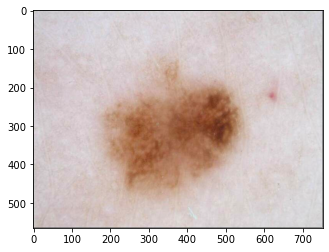

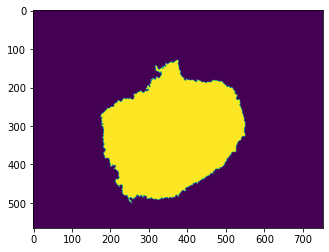

In [2]:
dataset_path = "D:/Drive D/Data Science/Semester 4/COMP3710/ISIC/ISIC2018_Task1-2_Training_Input_x2/*"

files = glob.glob(dataset_path)
random.shuffle(files)

train_data, validate_data, test_data = files[:2078], files[2078:2337], files[2337:2596]

train_seg, validate_seg, test_seg = train_data, validate_data, test_data



print(len(train_data))
print(len(validate_data))
print(len(test_data))

img = parse_image(train_data[0])

#print(img['image'])

plt.imshow(tf.keras.preprocessing.image.array_to_img(img['image']))
plt.show()
plt.imshow(tf.keras.preprocessing.image.array_to_img(img['seg_mask']))
plt.show()

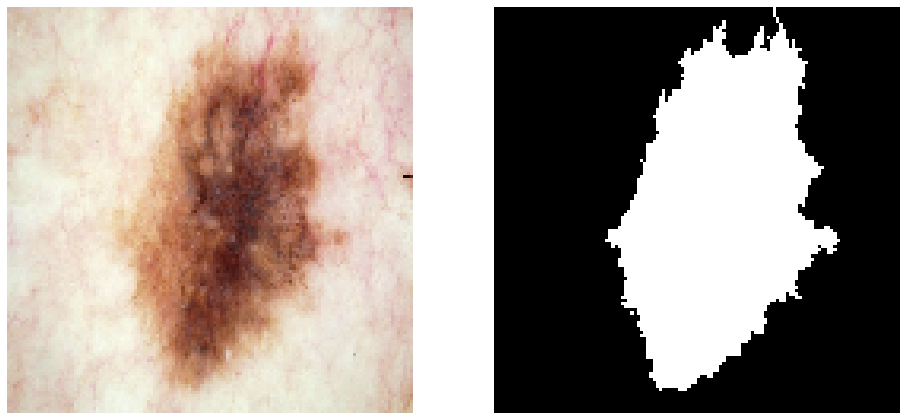

In [3]:
seed = 42
train_set = tf.data.Dataset.list_files(train_data, seed = seed)
train_set = train_set.map(parse_image)
test_set = tf.data.Dataset.list_files(test_data, seed = seed)
test_set = test_set.map(parse_image)
val_set = tf.data.Dataset.list_files(validate_data, seed = seed)
val_set = val_set.map(parse_image)

dataset = {"train": train_set, "val": val_set}

dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size = buffer_size, seed = seed)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(batch_size)
dataset['train'] = dataset['train'].prefetch(buffer_size = AUTOTUNE)

dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(batch_size)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    
display_sample([sample_image[0], sample_mask[0]])   


In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

input_size = (image_size, image_size, 3)
ini = "he_normal"

###Pseudocode for Improved U-Net
inputs = Input(shape = input_size)

#Conv layer 1
conv1 = Conv2D(16,3, activation = "relu", padding = "same", kernel_initializer = ini)(inputs)
conv1 = Conv2D(16,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv1)
#Conv layer 1 - context module
conv1 = LeakyReLU()(conv1)
conv1 = Conv2D(16,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv1)
conv1 = Conv2D(16,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv1)
conv1 = Dropout(0.3)(conv1)
conv1 = Normalization()(conv1)

#Conv Layer 2
conv2 = Conv2D(32, 3, 2, activation = "relu", padding = "same", kernel_initializer = ini)(conv1)
#conv2 = Conv2D(32, 3, 2, activation = "relu", padding = "same", kernel_initializer = ini)(conv2)
#Conv Layer 2 - Context Module
conv2 = Normalization()(conv2)
conv2 = LeakyReLU()(conv2)
conv2 = Conv2D(32,3, activation = "relu", padding= "same", kernel_initializer = ini)(conv2)
conv2 = Conv2D(32,3, activation = "relu", padding= "same", kernel_initializer = ini)(conv2)
conv2 = Dropout(0.3)(conv2)
conv2 = Normalization()(conv2)

#Conv Layer 3
conv3 = Conv2D(64,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv2)
#conv3 = Conv2D(64,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv3)
#conv3 = Conv2D(64,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv3)
#Conv Layer 3 - Context Module
conv3 = Normalization()(conv3)
conv3 = LeakyReLU()(conv3)
conv3 = Conv2D(64,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv3)
conv3 = Conv2D(64,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv3)
conv3 = Dropout(0.3)(conv3)
conv3 = Normalization()(conv3)

conv4 = Conv2D(128,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv3)
#conv4 = Conv2D(128,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv4)
#conv4 = Conv2D(128,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv4)
#conv4 = Conv2D(128,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv4)
#Conv layer 4 - Context Module
conv4 = Normalization()(conv4)
conv4 = LeakyReLU()(conv4)
conv4 = Conv2D(128,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv4)
conv4 = Conv2D(128,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv4)
conv4 = Dropout(0.3)(conv4)
conv4 = Normalization()(conv4)

#Conv layer 5
conv5 = Conv2D(256,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv4)
#conv5 = Conv2D(256,3,2, activation = "relu", padding = "same", kernel_initializer = ini)(conv5)
#Conv layer 5 - Context Module
conv5 = Normalization()(conv5)
conv5 = LeakyReLU()(conv5)
conv5 = Conv2D(256,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv5)
conv5 = Conv2D(256,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv5)
conv5 = Dropout(0.3)(conv5)
conv5 = Normalization()(conv5)


#Conv layer 6 - > upscale
conv6 = Conv2D(128,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv5)
conv6 = UpSampling2D((2,2))(conv6)
merge1 = concatenate([conv4,conv6], axis = 3)

#Conv layer 7 - Localisation/upscale
conv7 = Normalization()(merge1)
conv7 = LeakyReLU()(conv7)

conv7 = Conv2D(128,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv7)
conv7 = Conv2D(128,1, activation = "relu", padding = "same", kernel_initializer = ini)(conv7)
conv7 = Normalization()(conv7)
conv7 = LeakyReLU()(conv7)

#Conv layer 8 -> upscale
conv8 = Conv2D(64,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv7)
conv8 = UpSampling2D((2,2))(conv8)
merge2 = concatenate([conv3,conv8], axis = 3)

#conv layer 9 -> localisation/upscale
conv9 = Normalization()(merge2)
conv9 = LeakyReLU()(conv9)
conv9 = Conv2D(64,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv9)
conv9 = Conv2D(64,1, activation = "relu", padding = "same", kernel_initializer = ini)(conv9)
conv9 = Normalization()(conv9)
conv9 = LeakyReLU()(conv9)

#Conv layer 10 -> upscale
conv10 = Conv2D(32,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv9)
conv10 = UpSampling2D((2,2))(conv10)
merge3 = concatenate([conv2,conv10], axis =3)

#conv layer 11 - > localisation/upscale
conv11 = Normalization()(merge3)
conv11 = LeakyReLU()(conv11)
conv11 = Conv2D(32,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv11)
conv11 = Conv2D(32,1, activation = "relu", padding = "same", kernel_initializer = ini)(conv11)
conv11 = Normalization()(conv11)
conv11 = LeakyReLU()(conv11)


conv12 = Conv2D(16,3, activation = "relu", padding = "same", kernel_initializer = ini)(conv11)
conv12 = UpSampling2D((2,2))(conv12)
merge4 = concatenate([conv1, conv12], axis = 3)

conv13 = Conv2D(32,3,activation = "relu", padding = "same", kernel_initializer = ini)(conv12)

output = Conv2D(256,1, activation = "softmax")(conv13)

model = tf.keras.Model(inputs = inputs, outputs = output)
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
#








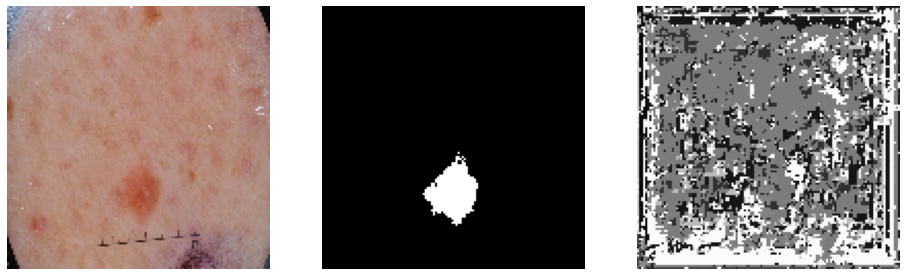

In [5]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis = -1)
    pred_mask = tf.expand_dims(pred_mask, axis = -1)
    return pred_mask

def show_predictions(dataset = None, num = 1):
    if dataset:
        for image,mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[1], mask[1], create_mask(pred_mask[1])])
    else:
        one_img_batch = sample_image[0][tf.newaxis,...]
        inference = model.predict(one_img_batch)
        pred_mask = create_mask(inference)
        display_sample([sample_image[0], sample_mask[0], pred_mask[0]])
        
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    show_predictions()
    

    
    

In [6]:
steps_per_epoch = 2078 // batch_size
validation_steps = 259 // batch_size
history = model.fit(dataset['train'], epochs = 15, steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, validation_data = dataset['val'])


Epoch 1/15
207/207 [==============================] - 67s 237ms/step - loss: 0.8819 - accuracy: 0.7476 - val_loss: 3.6166 - val_accuracy: 0.7603
Epoch 2/15
207/207 [==============================] - 44s 213ms/step - loss: 0.2873 - accuracy: 0.8990 - val_loss: 4.2640 - val_accuracy: 0.7828
Epoch 3/15
207/207 [==============================] - 45s 217ms/step - loss: 0.2335 - accuracy: 0.9170 - val_loss: 5.8585 - val_accuracy: 0.7771
Epoch 4/15
207/207 [==============================] - 44s 215ms/step - loss: 0.2056 - accuracy: 0.9267 - val_loss: 5.5472 - val_accuracy: 0.7773
Epoch 5/15
207/207 [==============================] - 44s 213ms/step - loss: 0.1912 - accuracy: 0.9311 - val_loss: 5.0868 - val_accuracy: 0.7827
Epoch 6/15
207/207 [==============================] - 45s 215ms/step - loss: 0.1828 - accuracy: 0.9331 - val_loss: 4.7644 - val_accuracy: 0.7760
Epoch 7/15
207/207 [==============================] - 45s 215ms/step - loss: 0.1700 - accuracy: 0.9370 - val_loss: 4.0900 - val_ac

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

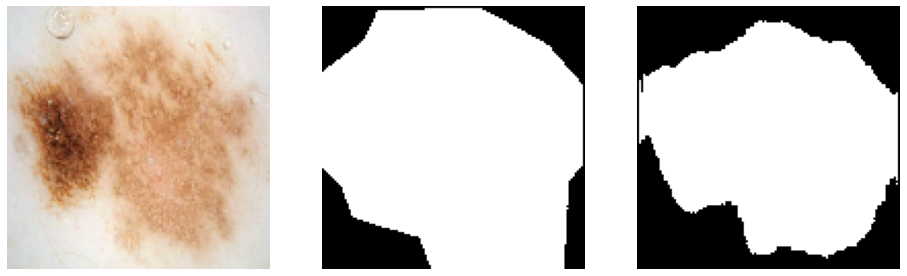

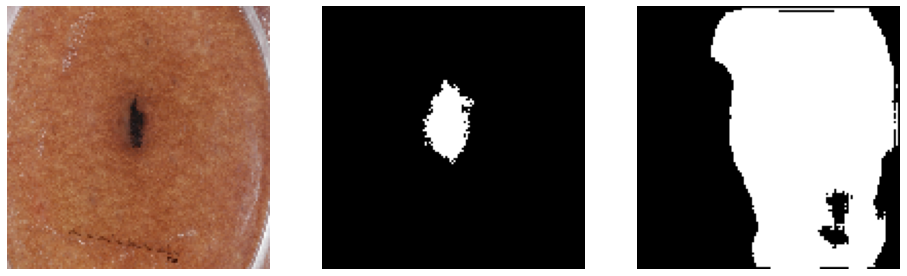

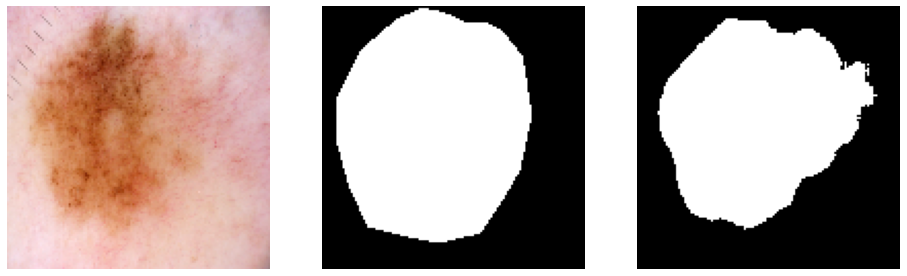

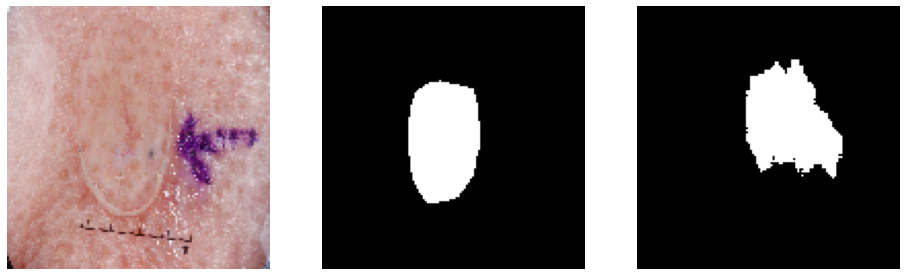

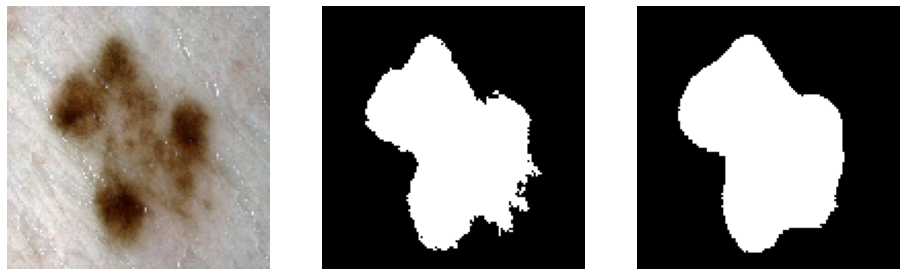

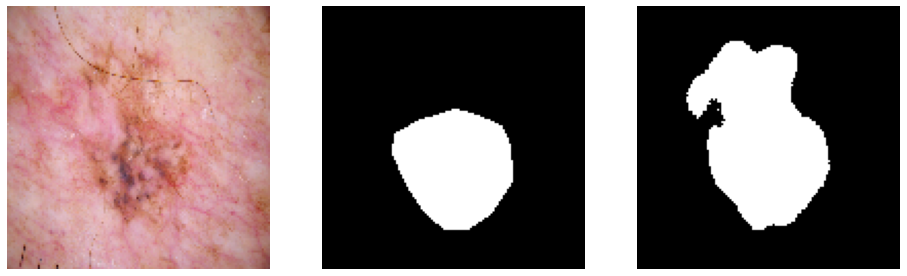

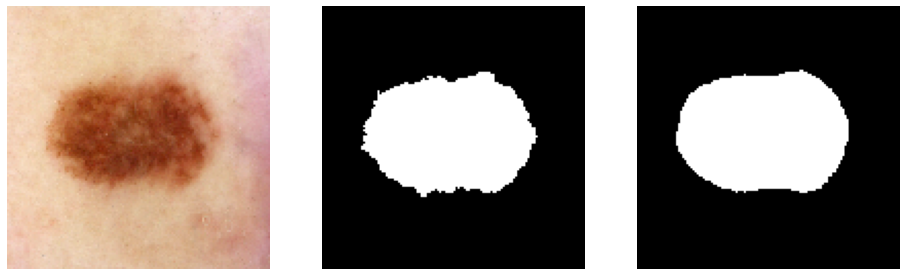

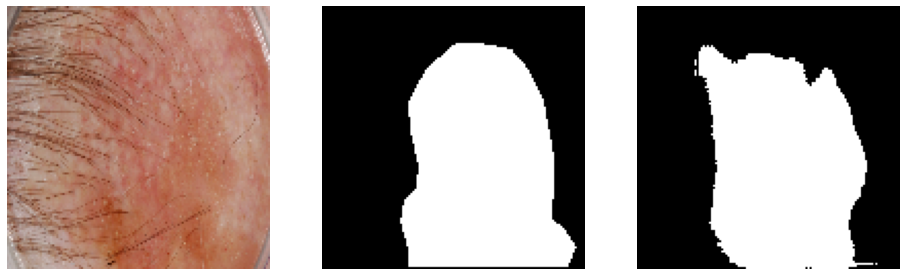

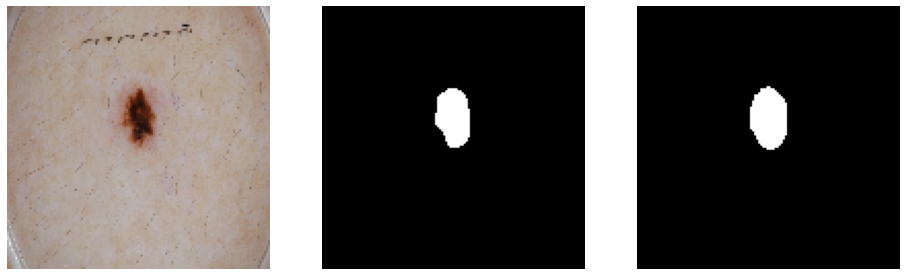

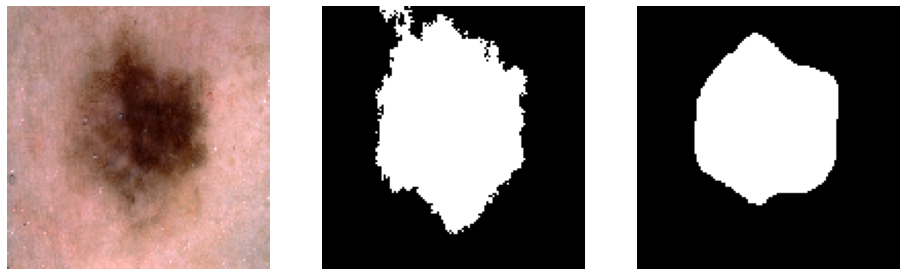

In [8]:
for image, mask in dataset['train'].take(10):
    sample_image, sample_mask = image, mask
    show_predictions()

In [9]:
#show_dice_accuracy(dataset['train'])

NameError: name 'show_dice_accuracy' is not defined

[1. 0.]
[  162735 41780305]
tf.Tensor([128 128   1], shape=(3,), dtype=int32)
[0 1]
[15993   391]
[0. 1.]
[16123   261]
tf.Tensor([ 10 128 128   1], shape=(4,), dtype=int32)


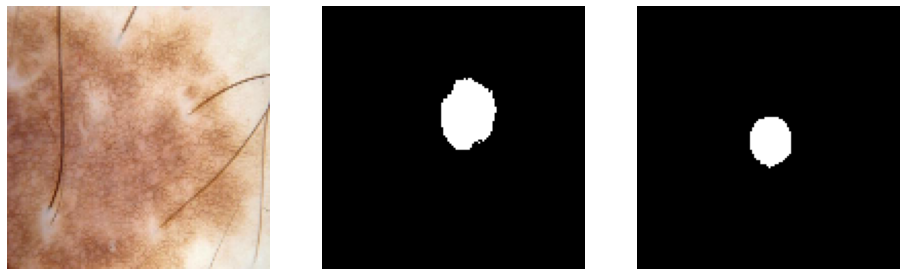

In [31]:
import numpy as np
import pandas as pd

def show_dice_accuracy(dataset):
    if dataset:
        for image, mask in dataset.take(1):
            pred_mask = model.predict(image)
            
            with tf.device('/device:CPU:0'):
                y,idx, count  = tf.unique_with_counts(tf.reshape(tf.round(tf.image.resize(pred_mask, size = (128,128), method = "nearest")), -1))
                print(y.numpy())
                print(count.numpy())
                print(tf.shape(create_mask(pred_mask[1])))
                pred_mask = create_mask(pred_mask[1])
                y,idx,count = tf.unique_with_counts(tf.reshape(tf.round(pred_mask), -1))
                print(y.numpy())
                print(count.numpy())
                
                y,idx, count  = tf.unique_with_counts(tf.reshape(tf.round(mask[1]), -1))
                print(y.numpy())
                print(count.numpy())
                print(tf.shape(mask))
            pred_mask = tf.math.round(pred_mask)
            #test_val = pred_mask.numpy()
            #test_val = pd.DataFrame(pred_mask)
            #print(tf.unique(tf.reshape(pred_mask, -1)))
            display_sample([image[2], mask[0], pred_mask])
            #print(pred_mask)
    else:
        return("Error - No dataset")
    
show_dice_accuracy(dataset['train'])